# Characterizing the GLODAP (v2.2021) dataset by region, developing model comparison tools

Objective: come up with a good global-level evalation for different models for carbonate chemistry parameters for Le Quere et al GMD paper

#### first step - clean up GLODAP database and identify key patterns by region

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import utils as ut
import lom


%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

#import mapfxn as mf
#reload(mf)

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [4]:

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    arval = array[idx]
    return(idx, arval)

tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
depths = (tmesh['gdept_1d'][0])

# A) Define regions, pipeline for cleaning up glodap data and binning to regions (run once via 'horse' flag)

Text(0.5, 0.98, 'check that norm of colours works')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


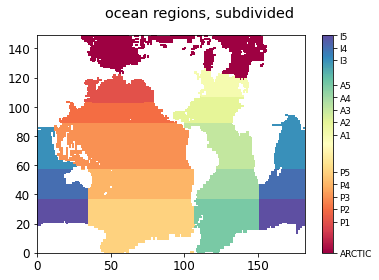

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


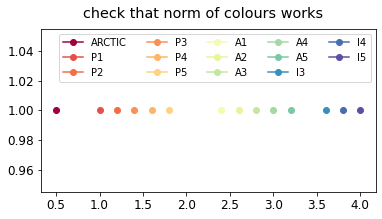

In [5]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('check that norm of colours works')

processing code for the glodap data is below, turn on **horse** to run

data itself can't be loaded into notebook, so is preprocesesd in `./saveGLODAPasdf.py`

## cleaning data pipeline (stitcher)

In [6]:
horse = False

In [7]:

if horse:
    df = pd.read_csv('/gpfs/home/mep22dku/scratch/SOZONE/evalOutput/datasets/GLODAPv2.2022_GLOBE_valid_DICTA_umolL.csv')
    df = df.sort_values(by = 'YR')
    tDIC = np.array(df['DIC'][:])
    tALK = np.array(df['ALK'][:])
    tCAST = np.array(df['CAST'][:])

    tSAL = np.array(df['SAL'][:])
    tTEMP = np.array(df['TEMP'][:])
    tPRES = np.array(df['PRES'][:])
    tLAT = np.array(df['LAT'][:])
    tLON = np.array(df['LON'][:])
    tYEAR = np.array(df['YR'])
    tMONTH = np.array(df['MONTH'])
    tSECT = np.array(df['SECT'])
    tDP = np.zeros_like(tSECT)
    tSTATION = np.array(df['STATION'])
    tCRUISE = np.array(df['CRUISE'])


    ### seasons
    tSEAS = np.zeros_like(tMONTH)
    tSEAS[(tMONTH == 12) | (tMONTH <3)] = 1 #summer
    tSEAS[(tMONTH >= 3) & (tMONTH <6)] = 2 #autumn
    tSEAS[(tMONTH >= 6) & (tMONTH <9)] = 3 #winter
    tSEAS[(tMONTH >= 9) & (tMONTH <12)] = 4
    
    print(np.size(tDIC[tPRES <10]))
    print(np.size(tALK[tPRES <10]))
    print(np.size(tDIC[tPRES <5]))
    print(np.size(tALK[tPRES <5]))

    # print(np.nanmin(tDIC))
    print(np.size(tDIC))
    
    ### unique

In [8]:
## assign unique depth profiles numbers for ease of plotting

if horse:
    np.shape(np.unique(tLAT))
    np.shape(tLAT)

    uniq_LATS = np.unique(tLAT)

    dpcount = 1
    for i in range(0, len(uniq_LATS)):
        #print(i)
        slat = uniq_LATS[i]  
        #print(slat)
        corlons = np.unique(tLON[tLAT == slat])
        #print(corlons)
        for j in range(0, len(corlons)):
            slon = corlons[j]
            coryrs = np.unique(tYEAR[(tLAT == slat) & (tLON == slon)])
            for k in range(0, len(coryrs)):
                syr = coryrs[k]
                cormos = np.unique(tMONTH[(tLAT == slat) & (tLON == slon) & (tYEAR == syr)])
                tw = (np.shape(cormos)[0])
                for l in range(0, len(cormos)):
                    smo = cormos[l]
                    tDP[(tLAT == slat) & (tLON == slon) & (tYEAR == syr) & (tMONTH == smo)] = dpcount
                    #print(np.shape(tDP[tDP == dpcount]))
                    dpcount = dpcount+1

    print('unique depth profiles, globally')
    print(dpcount-1)
    tDP = tDP.astype(int)

##### haversine-based code (via salishseacast team) for matching to grid and assigning regional masks is in glodap2grid.py, also moved to UTILS/Template

(because of the nemo double-pole thing we can't just use the meshmask to assign data to the grid at high latitudes)
code also in UTILS/Template
matching to grid occurs in glodap2grid.py

stitcher below:

In [9]:
##### it turns out this way is more accurate but painfully painfully slow,
#so we have put it into glodap2grid and batchsubmitted it. stitch together:
if horse:
    tY = np.zeros_like(tDIC)
    tX = np.zeros_like(tDIC)
    print(np.shape(tDIC))

    for i in range(0,20):
        ind = i*20000 
        w = pd.read_csv((f'./datasets/GLODAPv2.2022_GLOBAL_valid_DICTA_umolL_togrid_part{i}.csv'))
        tX[ind:ind+20000] = w['X'][ind:ind+20000]
        tY[ind:ind+20000] = w['Y'][ind:ind+20000]

bin to depths: 

interpolating these depth profiles is hard because of how sporadic they are. 

I have made the choice to simply assign a z-value to each observation based on which nominal nemo-grid depth is closest. 

In [10]:
#### make regions and get depths
if horse:
    tREG = np.zeros_like(tY)

    for i in range(0,len(tX)):
        tREG[i] = maskno[int(tY[i]), int(tX[i])]
        
# GET DEPTHS
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    depths = (tmesh['gdept_1d'][0])

    tZ = np.zeros_like(tPRES)
    tZdep = np.zeros_like(tPRES)
    for i in range(0,len(tZ)):
        tZdep[i], tZ[i] = find_nearest(depths, tPRES[i])
        
    df = pd.DataFrame([tYEAR,tMONTH,tDIC,tALK,tSAL,tTEMP,tPRES,tLAT,tLON, tY, tX, tZ, tZdep, tDP, tREG, tSTATION, tCRUISE]).T
        # df = df.sort_values(by = tYEAR)
    df.columns = ['YR', 'MONTH', 'DIC', 'ALK', 'SAL', 'TEMP', 'PRES', 'LAT', 'LON', 'Y', 'X', 'Z', 'Zdep', 'DP', 'REG', 'STATION', 'CRUISE']
    df.wheremade = 'SOpCO2Cycle/GLODAP_carbon_fullglobe.ipynb'
    df.to_csv('./datasets/GLODAPv2.2022_GLOBAL_valid_DICTA_umolL_STITCHED.csv')

# B) - load adjusted dataset, understand distribution of DIC/ALK data by season and depth

There are around 370,000 valid data points total, around 100,000 since 2010

#### Anticipated difficulty in comparing in-situ DIC data model-obs: it changes with time. 

For DIC, one problem when comparing model with observations is incorporating the time axis, because DIC concentration changes with time, *but not predictably*. By how much is sort of hard to estimate, because it depends on things like age of water, Revelle factor when it was last at surface, AOU, etc. In all regions, DIC will have changed the most at surface and the least at depth. (See Gruber 1996, methods used in Jarnikova 2022)

One solution is to only consider observations since 2010, ie observations less than 10 years old. Not ideal, but maybe fairer than other methods?

Let's visualize all data, and data since 2010, to see where we stand:

# start here

In [11]:
df = pd.read_csv('./datasets/GLODAPv2.2022_GLOBAL_valid_DICTA_umolL_STITCHED.csv')

In [12]:
tDIC = np.array(df['DIC'][:])
tALK = np.array(df['ALK'][:])


tSAL = np.array(df['SAL'][:])
tTEMP = np.array(df['TEMP'][:])
tPRES = np.array(df['PRES'][:])


dens = seawater.dens(tSAL,tTEMP,tPRES)
tDIC_umolkg = tDIC*1000/dens
tALK_umolkg = tALK*1000/dens

tLAT = np.array(df['LAT'][:])
tLON = np.array(df['LON'][:])
tYEAR = np.array(df['YR'])
tMONTH = np.array(df['MONTH'])
tSTATION = np.array(df['STATION'])
tY = np.array(df['Y'])
tX = np.array(df['X'])
tZ = np.array(df['Zdep'])
tDP = np.array(df['DP'])
tREG = np.array(df['REG'])
tSEAS = np.zeros_like(tMONTH)
tSEAS[(tMONTH == 12) | (tMONTH <3)] = 1 #summer
tSEAS[(tMONTH >= 3) & (tMONTH <6)] = 2 #autumn
tSEAS[(tMONTH >= 6) & (tMONTH <9)] = 3 #winter
tSEAS[(tMONTH >= 9) & (tMONTH <12)] = 4

In [13]:
print(len(np.unique(tSTATION)))

3188


tZ

Text(0.5, 0.98, 'year of gathering, depth and season of all available observations')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


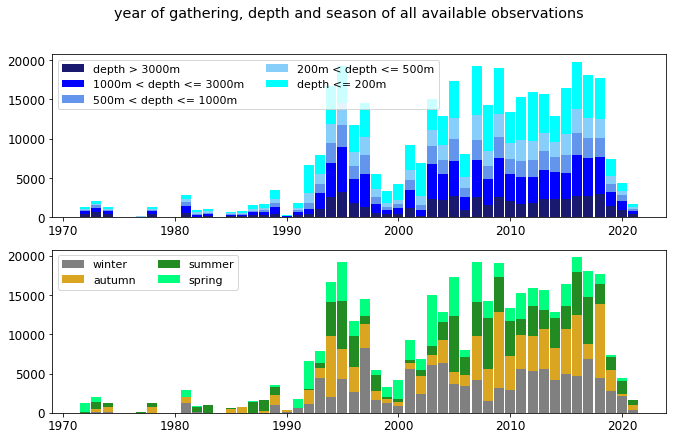

In [14]:
yrs = np.arange(1972,2022,1)
OBS_depths = np.zeros([5,len(yrs)])
OBS_seas = np.zeros([4,len(yrs)])
OBS_lats = np.zeros([6,len(yrs)])
OBS_sects = np.zeros([3,len(yrs)])

for i in range(0,len(yrs)):
    tyr = yrs[i]

    OBS_depths[0,i] = np.size(tDIC[(tYEAR == tyr) & (tPRES<=200)])
    OBS_depths[1,i] = np.size(tDIC[(tYEAR == tyr) & (tPRES>200) & (tPRES<=500)]) 
    OBS_depths[2,i] = np.size(tDIC[(tYEAR == tyr) & (tPRES>500) & (tPRES<=1000)]) 
    OBS_depths[3,i] = np.size(tDIC[(tYEAR == tyr) & (tPRES>1000) & (tPRES<=3000)]) 
    OBS_depths[4,i] = np.size(tDIC[(tYEAR == tyr) & (tPRES>3000)]) 
    
    #spring
    OBS_seas[0,i] = np.size(tDIC[(tYEAR == tyr) & (tMONTH<=11) & (tMONTH>8)]) #spring
    OBS_seas[1,i] = np.size(tDIC[(tYEAR == tyr) & ((tMONTH==12) | (tMONTH<=2))])  #sumer
    OBS_seas[2,i] = np.size(tDIC[(tYEAR == tyr) & (tMONTH>2) & (tMONTH<=5)]) #autum
    OBS_seas[3,i] = np.size(tDIC[(tYEAR == tyr) & (tMONTH>5) & (tMONTH<=8)]) #winter

fact = 0.55
fig, axs = plt.subplots(2,1, figsize=(20*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
fs = 11
width = 0.9
axs[0].bar(yrs,OBS_depths[4,:],width, color = 'midnightblue', label = 'depth > 3000m')
axs[0].bar(yrs,OBS_depths[3,:],width, bottom = OBS_depths[4,:], color = 'b', label = '1000m < depth <= 3000m')
axs[0].bar(yrs,OBS_depths[2,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:], color = 'cornflowerblue', label = '500m < depth <= 1000m')
axs[0].bar(yrs,OBS_depths[1,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:]+OBS_depths[2,:], color = 'lightskyblue', label = '200m < depth <= 500m')
axs[0].bar(yrs,OBS_depths[0,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:]+OBS_depths[2,:]+OBS_depths[1,:], color = 'cyan', label = 'depth <= 200m')
axs[0].legend(ncol = 2, loc = 'best', fontsize = fs)

axs[1].bar(yrs,OBS_seas[3,:],width,  color = 'grey', label = 'winter')
axs[1].bar(yrs,OBS_seas[2,:],width, bottom = OBS_seas[3,:], color = 'goldenrod', label = 'autumn')
axs[1].bar(yrs,OBS_seas[1,:],width, bottom = OBS_seas[3,:]+OBS_seas[2,:], color = 'forestgreen', label = 'summer')
axs[1].bar(yrs,OBS_seas[0,:],width, bottom = OBS_seas[3,:]+OBS_seas[2,:]+OBS_seas[1,:], color = 'springgreen', label = 'spring')
axs[1].legend(ncol = 2, loc = 'best', fontsize = fs)

plt.suptitle('year of gathering, depth and season of all available observations')

proportion of data since 2010
0.3711086082883252


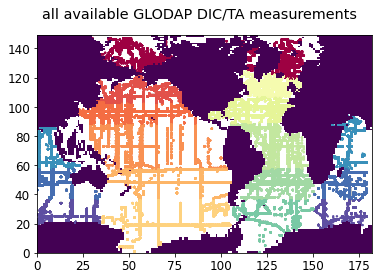

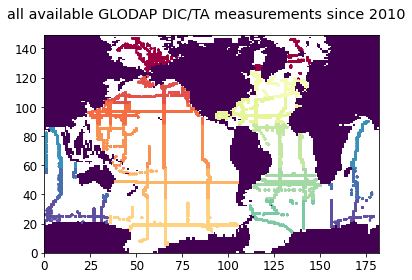

In [15]:
continents = np.copy(maskno)
continents[np.isnan(maskno)] = 10
continents[continents <10] = np.nan

filt = tYEAR < 4000
fig = plt.figure()
plt.scatter(tX[filt], tY[filt], c = tREG[filt], s = 2, vmin = 0.5, vmax = 4, cmap = tcm) 
plt.pcolormesh(continents)
plt.suptitle('all available GLODAP DIC/TA measurements')

tyear = 2010
filt = tYEAR >=tyear
fig = plt.figure()
plt.scatter(tX[filt], tY[filt], c = tREG[filt], s = 2, vmin = 0.5, vmax = 4, cmap = tcm) 
plt.pcolormesh(continents)
plt.suptitle(f'all available GLODAP DIC/TA measurements since {tyear}')


print('proportion of data since 2010')
print((np.shape(tYEAR[tYEAR >2010])[0])/(np.shape(tYEAR[tYEAR <3000])[0]))


##### why the hell are some measurements in a vetted database with good quality flags (flag = 2) less than 0?

nb write someone

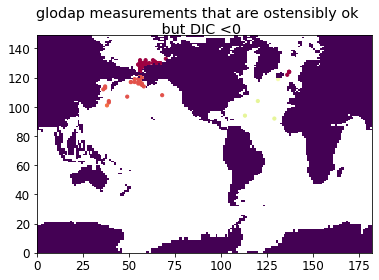

In [16]:
continents = np.copy(maskno)
continents[np.isnan(maskno)] = 10
continents[continents <10] = np.nan

filt = (tDIC < 0)
fig = plt.figure()
plt.scatter(tX[filt], tY[filt], c = tREG[filt], s = 10, vmin = 0.5, vmax = 4, cmap = tcm) 
plt.pcolormesh(continents)
plt.suptitle('glodap measurements that are ostensibly ok \n but DIC <0')

tDIC[tDIC <0] = np.nan
tALK[tALK <0] = np.nan
tDIC_umolkg[tDIC <0] = np.nan
tALK_umolkg[tALK <0] = np.nan


## 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


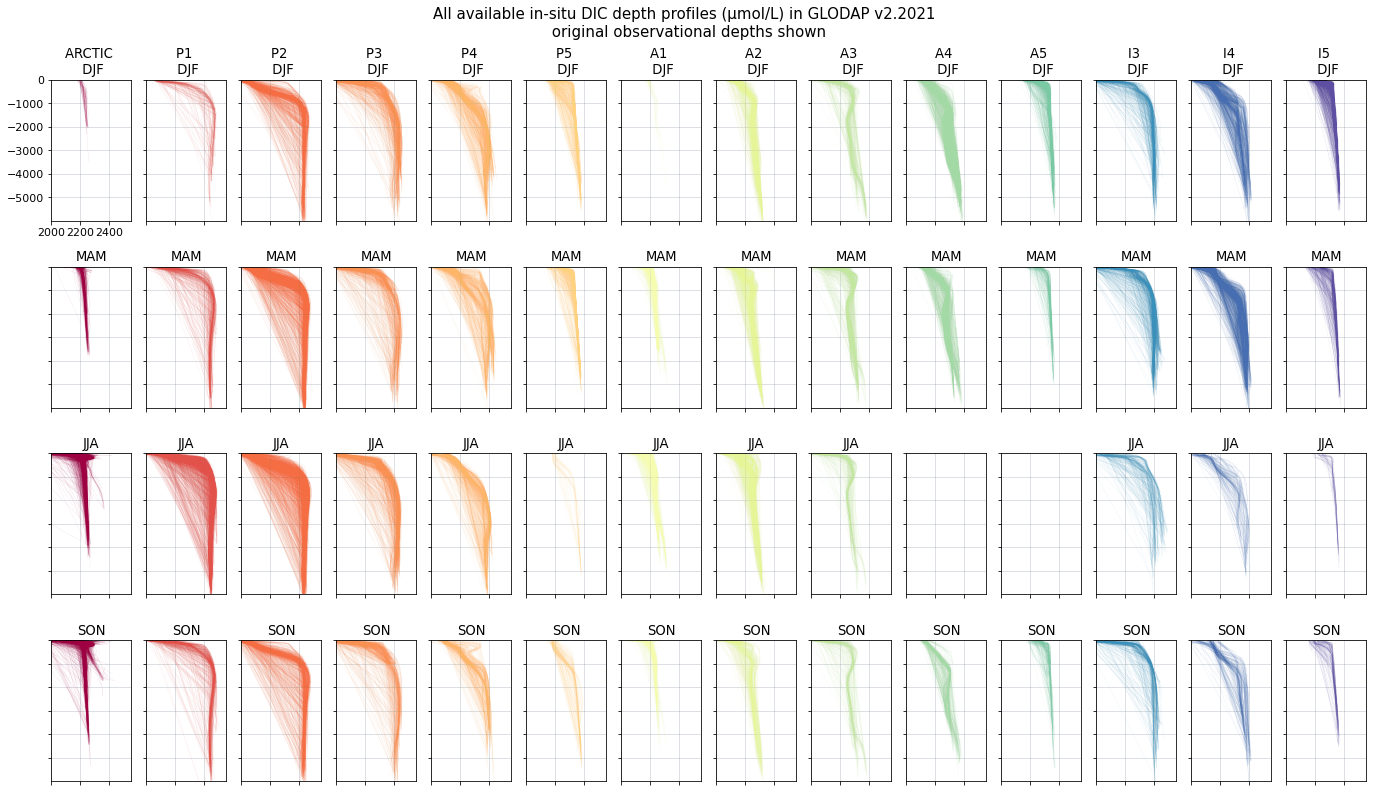

In [17]:
plt.rcParams.update({'font.size': 11})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 11}

plt.rc('font', **font)

seasons = ['DJF', 'MAM', 'JJA', 'SON']

fact = 1.6
fig, axs = plt.subplots(4,14, figsize=(12*fact, 7*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ind = 0
for r in range(0,len(regs)):
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tSEAS == ind+1) & (tREG == tno))
    q = np.unique(tDP[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC[tDP == q[d]]; tpres = tPRES[tDP == q[d]]
        axs[r+ind*14].plot(tplt, -tpres, color = tcol, linewidth = 0.2, alpha = 0.2)
        axs[r+ind*14].set_title(f'{regs[r]} \n {seasons[ind]}')
ind = 1
for r in range(0,len(regs)):
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tSEAS == ind+1) & (tREG == tno))
    q = np.unique(tDP[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC[tDP == q[d]]; tpres = tPRES[tDP == q[d]]
        axs[r+ind*14].plot(tplt, -tpres, color = tcol, linewidth = 0.2, alpha = 0.2)
        axs[r+ind*14].set_title(f'{seasons[ind]}')
ind = 2
for r in range(0,len(regs)):
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tSEAS == ind+1) & (tREG == tno))
    q = np.unique(tDP[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC[tDP == q[d]]; tpres = tPRES[tDP == q[d]]
        axs[r+ind*14].plot(tplt, -tpres, color = tcol, linewidth = 0.2, alpha = 0.2)
        axs[r+ind*14].set_title(f'{seasons[ind]}')
ind = 3
for r in range(0,len(regs)):
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tSEAS == ind+1) & (tREG == tno))
    q = np.unique(tDP[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC[tDP == q[d]]; tpres = tPRES[tDP == q[d]]
        axs[r+ind*14].plot(tplt, -tpres, color = tcol, linewidth = 0.2, alpha = 0.2)
        axs[r+ind*14].set_title(f'{seasons[ind]}')        
        
for i in range(0,4*14):
    axs[i].set_ylim([-6000, 0])
    axs[i].set_xlim([2000,2550])
    axs[i].set_xticks([2000,2200,2400])
    axs[i].set_yticks([-5000,-4000,-3000,-2000,-1000,0])
    axs[i].grid(color = 'slategrey', alpha = 0.3)
    
for i in range(1,4*14):
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    #axs[i].grid(color = 'slategrey', alpha = 0.3)

plt.suptitle('All available in-situ DIC depth profiles (µmol/L) in GLODAP v2.2021 \n original observational depths shown', fontsize = 15)
plt.tight_layout()

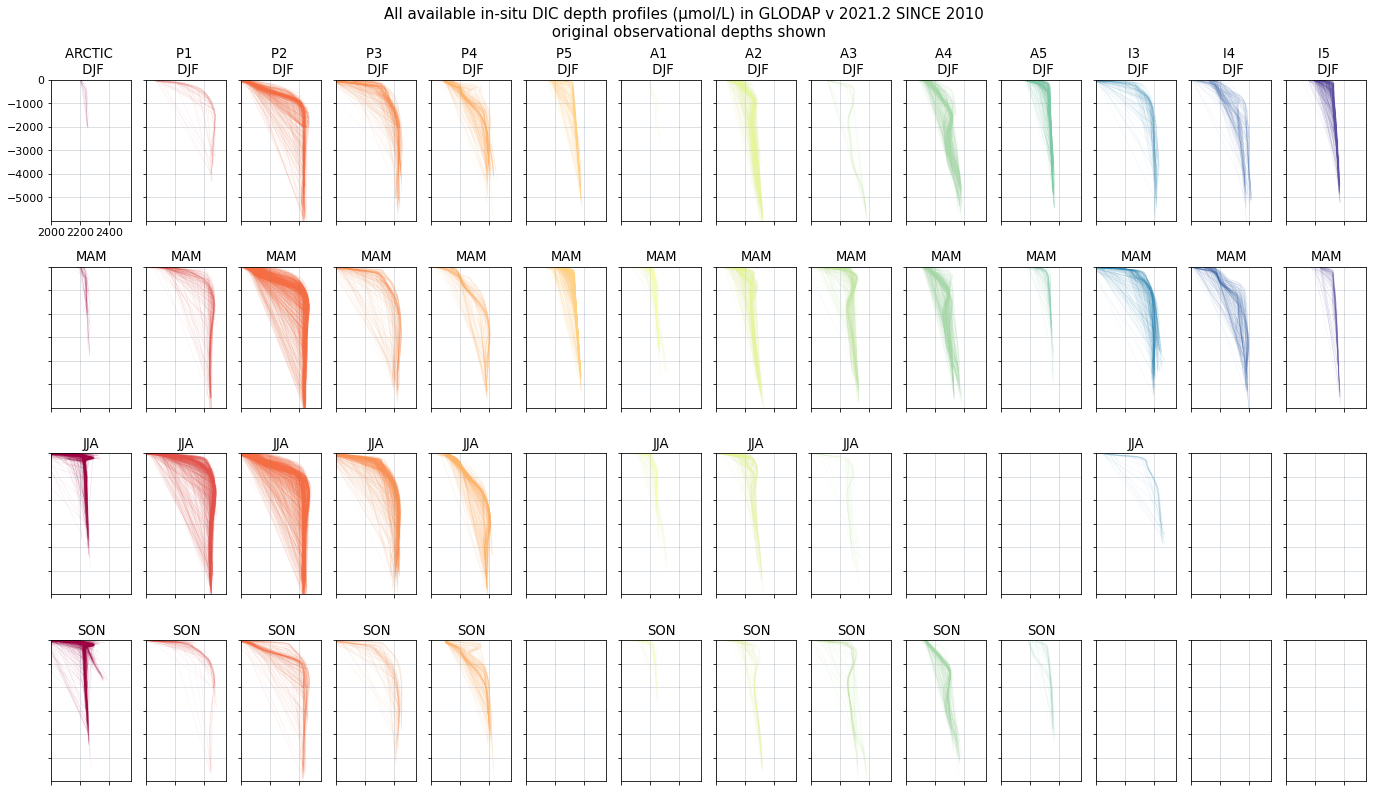

In [18]:
plt.rcParams.update({'font.size': 11})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 11}

plt.rc('font', **font)

seasons = ['DJF', 'MAM', 'JJA', 'SON']

fact = 1.6
fig, axs = plt.subplots(4,14, figsize=(12*fact, 7*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ind = 0
for r in range(0,len(regs)):
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tSEAS == ind+1) & (tREG == tno) & (tYEAR >= 2010))
    q = np.unique(tDP[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC[tDP == q[d]]; tpres = tPRES[tDP == q[d]]
        axs[r+ind*14].plot(tplt, -tpres, color = tcol, linewidth = 0.2, alpha = 0.2)
        axs[r+ind*14].set_title(f'{regs[r]} \n {seasons[ind]}')
ind = 1
for r in range(0,len(regs)):
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tSEAS == ind+1) & (tREG == tno) & (tYEAR >= 2010))
    q = np.unique(tDP[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC[tDP == q[d]]; tpres = tPRES[tDP == q[d]]
        axs[r+ind*14].plot(tplt, -tpres, color = tcol, linewidth = 0.2, alpha = 0.2)
        axs[r+ind*14].set_title(f'{seasons[ind]}')
ind = 2
for r in range(0,len(regs)):
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tSEAS == ind+1) & (tREG == tno) & (tYEAR >= 2010))
    q = np.unique(tDP[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC[tDP == q[d]]; tpres = tPRES[tDP == q[d]]
        axs[r+ind*14].plot(tplt, -tpres, color = tcol, linewidth = 0.2, alpha = 0.2)
        axs[r+ind*14].set_title(f'{seasons[ind]}')
ind = 3
for r in range(0,len(regs)):
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tSEAS == ind+1) & (tREG == tno) & (tYEAR >= 2010))
    q = np.unique(tDP[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC[tDP == q[d]]; tpres = tPRES[tDP == q[d]]
        axs[r+ind*14].plot(tplt, -tpres, color = tcol, linewidth = 0.2, alpha = 0.2)
        axs[r+ind*14].set_title(f'{seasons[ind]}')        
        
for i in range(0,4*14):
    axs[i].set_ylim([-6000, 0])
    axs[i].set_xlim([2000,2550])
    axs[i].set_xticks([2000,2200,2400])
    axs[i].set_yticks([-5000,-4000,-3000,-2000,-1000,0])
    axs[i].grid(color = 'slategrey', alpha = 0.3)
    
for i in range(1,4*14):
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    #axs[i].grid(color = 'slategrey', alpha = 0.3)

plt.suptitle('All available in-situ DIC depth profiles (µmol/L) in GLODAP v 2021.2 SINCE 2010 \n original observational depths shown', fontsize = 15)
plt.tight_layout()

### code to calculate seasonal depth profiles by subregion

In [19]:
print('calculating depth profiles')
seas = ['DJF', 'MAM', 'JJA', 'SON']
for r in range(0,len(regs)):
    grandar = np.zeros([4,31])
    for ind in range(0,4):
        tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
        tfilt = ((tSEAS == ind+1) & (tREG == tno))
        q = np.unique(tDP[tfilt])
        storar = np.zeros([len(q),31])
        for d in range(0, len(q)):
            tplt = tDIC[tDP == q[d]]; 
            tpres = tPRES[tDP == q[d]];
            tzed = (tZ[tDP == q[d]])
            tzed = tzed.astype(int)
            tzedun = np.unique(tzed)
            if len(tzed) == len(tzedun):
                storar[d,tzed] = tplt
            else: 
                for i in range(0, len(tzedun)):
                    storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
        storar[storar == 0] = np.nan
        grandar[ind,:] = (np.nanmean(storar, axis = 0))
    regdict[regs[r]]['DICseasonalDP'] = grandar

grandar = np.zeros([4,31])
for ind in range(0,4):
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tSEAS == ind+1))
    q = np.unique(tDP[tfilt])
    storar = np.zeros([len(q),31])
    for d in range(0, len(q)):
        tplt = tDIC[tDP == q[d]]; 
        tpres = tPRES[tDP == q[d]];
        tzed = (tZ[tDP == q[d]])
        tzed = tzed.astype(int)
        tzedun = np.unique(tzed)
        if len(tzed) == len(tzedun):
            storar[d,tzed] = tplt
        else: 
            for i in range(0, len(tzedun)):
                storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
    storar[storar == 0] = np.nan
    grandar[ind,:] = (np.nanmean(storar, axis = 0))
allreg_DICseasonalDP = grandar
    
    
for r in range(0,len(regs)):
    grandar = np.zeros([4,31])
    for ind in range(0,4):
        tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
        tfilt = ((tSEAS == ind+1) & (tREG == tno))
        #print(seas[ind])
        
        q = np.unique(tDP[tfilt])
        storar = np.zeros([len(q),31])
        for d in range(0, len(q)):
            tplt = tALK[tDP == q[d]]; 
            tpres = tPRES[tDP == q[d]];
            tzed = (tZ[tDP == q[d]])
            tzed = tzed.astype(int)
            tzedun = np.unique(tzed)
            if len(tzed) == len(tzedun):
                storar[d,tzed] = tplt
            else: 
                for i in range(0, len(tzedun)):
                    storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
        storar[storar == 0] = np.nan
        grandar[ind,:] = (np.nanmean(storar, axis = 0))
    regdict[regs[r]]['ALKseasonalDP'] = grandar

grandar = np.zeros([4,31])
for ind in range(0,4):
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tSEAS == ind+1))
    #print(seas[ind])

    q = np.unique(tDP[tfilt])
    storar = np.zeros([len(q),31])
    for d in range(0, len(q)):
        tplt = tALK[tDP == q[d]]; 
        tpres = tPRES[tDP == q[d]];
        tzed = (tZ[tDP == q[d]])
        tzed = tzed.astype(int)
        tzedun = np.unique(tzed)
        if len(tzed) == len(tzedun):
            storar[d,tzed] = tplt
        else: 
            for i in range(0, len(tzedun)):
                storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
    storar[storar == 0] = np.nan
    grandar[ind,:] = (np.nanmean(storar, axis = 0))
allreg_ALKseasonalDP= grandar
print('complete')

calculating depth profiles
complete


In [20]:
print('calculating depth profiles')
seas = ['DJF', 'MAM', 'JJA', 'SON']
for r in range(0,len(regs)):
    grandar = np.zeros([4,31])
    for ind in range(0,4):
        tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
        tfilt = ((tSEAS == ind+1) & (tREG == tno))
        q = np.unique(tDP[tfilt])
        storar = np.zeros([len(q),31])
        for d in range(0, len(q)):
            tplt = tDIC_umolkg[tDP == q[d]]; 
            tpres = tPRES[tDP == q[d]];
            tzed = (tZ[tDP == q[d]])
            tzed = tzed.astype(int)
            tzedun = np.unique(tzed)
            if len(tzed) == len(tzedun):
                storar[d,tzed] = tplt
            else: 
                for i in range(0, len(tzedun)):
                    storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
        storar[storar == 0] = np.nan
        grandar[ind,:] = (np.nanmean(storar, axis = 0))
    regdict[regs[r]]['DIC_umolkg_seasonalDP'] = grandar

grandar = np.zeros([4,31])
for ind in range(0,4):
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tSEAS == ind+1))
    q = np.unique(tDP[tfilt])
    storar = np.zeros([len(q),31])
    for d in range(0, len(q)):
        tplt = tDIC_umolkg[tDP == q[d]]; 
        tpres = tPRES[tDP == q[d]];
        tzed = (tZ[tDP == q[d]])
        tzed = tzed.astype(int)
        tzedun = np.unique(tzed)
        if len(tzed) == len(tzedun):
            storar[d,tzed] = tplt
        else: 
            for i in range(0, len(tzedun)):
                storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
    storar[storar == 0] = np.nan
    grandar[ind,:] = (np.nanmean(storar, axis = 0))
allreg_DIC_umolkg_seasonalDP = grandar
    
    
for r in range(0,len(regs)):
    grandar = np.zeros([4,31])
    for ind in range(0,4):
        tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
        tfilt = ((tSEAS == ind+1) & (tREG == tno))
        #print(seas[ind])
        
        q = np.unique(tDP[tfilt])
        storar = np.zeros([len(q),31])
        for d in range(0, len(q)):
            tplt = tALK_umolkg[tDP == q[d]]; 
            tpres = tPRES[tDP == q[d]];
            tzed = (tZ[tDP == q[d]])
            tzed = tzed.astype(int)
            tzedun = np.unique(tzed)
            if len(tzed) == len(tzedun):
                storar[d,tzed] = tplt
            else: 
                for i in range(0, len(tzedun)):
                    storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
        storar[storar == 0] = np.nan
        grandar[ind,:] = (np.nanmean(storar, axis = 0))
    regdict[regs[r]]['ALK_umolkg_seasonalDP'] = grandar

grandar = np.zeros([4,31])
for ind in range(0,4):
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tSEAS == ind+1))
    #print(seas[ind])

    q = np.unique(tDP[tfilt])
    storar = np.zeros([len(q),31])
    for d in range(0, len(q)):
        tplt = tALK_umolkg[tDP == q[d]]; 
        tpres = tPRES[tDP == q[d]];
        tzed = (tZ[tDP == q[d]])
        tzed = tzed.astype(int)
        tzedun = np.unique(tzed)
        if len(tzed) == len(tzedun):
            storar[d,tzed] = tplt
        else: 
            for i in range(0, len(tzedun)):
                storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
    storar[storar == 0] = np.nan
    grandar[ind,:] = (np.nanmean(storar, axis = 0))
allreg_ALK_umolkg_seasonalDP= grandar
print('complete')

calculating depth profiles
complete


In [21]:
for r in range(0,len(regs)):
    grandar = np.zeros([31])
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tREG == tno))
    q = np.unique(tDP[tfilt])
    storar = np.zeros([len(q),31])
    for d in range(0, len(q)):
        tplt = tDIC[tDP == q[d]]; 
        tpres = tPRES[tDP == q[d]];
        tzed = (tZ[tDP == q[d]])
        tzed = tzed.astype(int)
        tzedun = np.unique(tzed)
        if len(tzed) == len(tzedun):
            storar[d,tzed] = tplt
        else: 
            for i in range(0, len(tzedun)):
                storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
    storar[storar == 0] = np.nan
    grandar = (np.nanmean(storar, axis = 0))
    regdict[regs[r]]['DICfyDP'] = grandar
    
grandar = np.zeros([31])
q = np.unique(tDP)
storar = np.zeros([len(q),31])
for d in range(0, len(q)):
    tplt = tDIC[tDP == q[d]]; 
    tpres = tPRES[tDP == q[d]];
    tzed = (tZ[tDP == q[d]])
    tzed = tzed.astype(int)
    tzedun = np.unique(tzed)
    if len(tzed) == len(tzedun):
        storar[d,tzed] = tplt
    else: 
        for i in range(0, len(tzedun)):
            storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
storar[storar == 0] = np.nan
grandar = (np.nanmean(storar, axis = 0))
allreg_DICfyDP = grandar

for r in range(0,len(regs)):
    grandar = np.zeros([31])
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tREG == tno))
    q = np.unique(tDP[tfilt])
    storar = np.zeros([len(q),31])
    for d in range(0, len(q)):
        tplt = tALK[tDP == q[d]]; 
        tpres = tPRES[tDP == q[d]];
        tzed = (tZ[tDP == q[d]])
        tzed = tzed.astype(int)
        tzedun = np.unique(tzed)
        if len(tzed) == len(tzedun):
            storar[d,tzed] = tplt
        else: 
            for i in range(0, len(tzedun)):
                storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
    storar[storar == 0] = np.nan
    grandar = (np.nanmean(storar, axis = 0))
    regdict[regs[r]]['ALKfyDP'] = grandar
    
grandar = np.zeros([31])
q = np.unique(tDP)
storar = np.zeros([len(q),31])
for d in range(0, len(q)):
    tplt = tALK[tDP == q[d]]; 
    tpres = tPRES[tDP == q[d]];
    tzed = (tZ[tDP == q[d]])
    tzed = tzed.astype(int)
    tzedun = np.unique(tzed)
    if len(tzed) == len(tzedun):
        storar[d,tzed] = tplt
    else: 
        for i in range(0, len(tzedun)):
            storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
storar[storar == 0] = np.nan
grandar = (np.nanmean(storar, axis = 0))
allreg_ALKfyDP = grandar

In [22]:
for r in range(0,len(regs)):
    grandar = np.zeros([31])
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tREG == tno))
    q = np.unique(tDP[tfilt])
    storar = np.zeros([len(q),31])
    for d in range(0, len(q)):
        tplt = tDIC_umolkg[tDP == q[d]]; 
        tpres = tPRES[tDP == q[d]];
        tzed = (tZ[tDP == q[d]])
        tzed = tzed.astype(int)
        tzedun = np.unique(tzed)
        if len(tzed) == len(tzedun):
            storar[d,tzed] = tplt
        else: 
            for i in range(0, len(tzedun)):
                storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
    storar[storar == 0] = np.nan
    grandar = (np.nanmean(storar, axis = 0))
    regdict[regs[r]]['DIC_umolkg_fyDP'] = grandar
    
grandar = np.zeros([31])
q = np.unique(tDP)
storar = np.zeros([len(q),31])
for d in range(0, len(q)):
    tplt = tDIC_umolkg[tDP == q[d]]; 
    tpres = tPRES[tDP == q[d]];
    tzed = (tZ[tDP == q[d]])
    tzed = tzed.astype(int)
    tzedun = np.unique(tzed)
    if len(tzed) == len(tzedun):
        storar[d,tzed] = tplt
    else: 
        for i in range(0, len(tzedun)):
            storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
storar[storar == 0] = np.nan
grandar = (np.nanmean(storar, axis = 0))
allreg_DIC_umolkg_fyDP = grandar

for r in range(0,len(regs)):
    grandar = np.zeros([31])
    tno = regdict[regs[r]]['number']; tcol = regdict[regs[r]]['colour']
    tfilt = ((tREG == tno))
    q = np.unique(tDP[tfilt])
    storar = np.zeros([len(q),31])
    for d in range(0, len(q)):
        tplt = tALK_umolkg[tDP == q[d]]; 
        tpres = tPRES[tDP == q[d]];
        tzed = (tZ[tDP == q[d]])
        tzed = tzed.astype(int)
        tzedun = np.unique(tzed)
        if len(tzed) == len(tzedun):
            storar[d,tzed] = tplt
        else: 
            for i in range(0, len(tzedun)):
                storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
    storar[storar == 0] = np.nan
    grandar = (np.nanmean(storar, axis = 0))
    regdict[regs[r]]['ALK_umolkg_fyDP'] = grandar
    
grandar = np.zeros([31])
q = np.unique(tDP)
storar = np.zeros([len(q),31])
for d in range(0, len(q)):
    tplt = tALK_umolkg[tDP == q[d]]; 
    tpres = tPRES[tDP == q[d]];
    tzed = (tZ[tDP == q[d]])
    tzed = tzed.astype(int)
    tzedun = np.unique(tzed)
    if len(tzed) == len(tzedun):
        storar[d,tzed] = tplt
    else: 
        for i in range(0, len(tzedun)):
            storar[d,tzed[i]] = np.nanmean(tplt[tzed == tzedun[i]])
storar[storar == 0] = np.nan
grandar = (np.nanmean(storar, axis = 0))
allreg_ALK_umolkg_fyDP = grandar

# best depth profiles

Text(0.5, 0.92, 'mean GLODAPv2.2022 DIC (solid) and TA (dotted) depth profiles by region and season, µmol/L')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


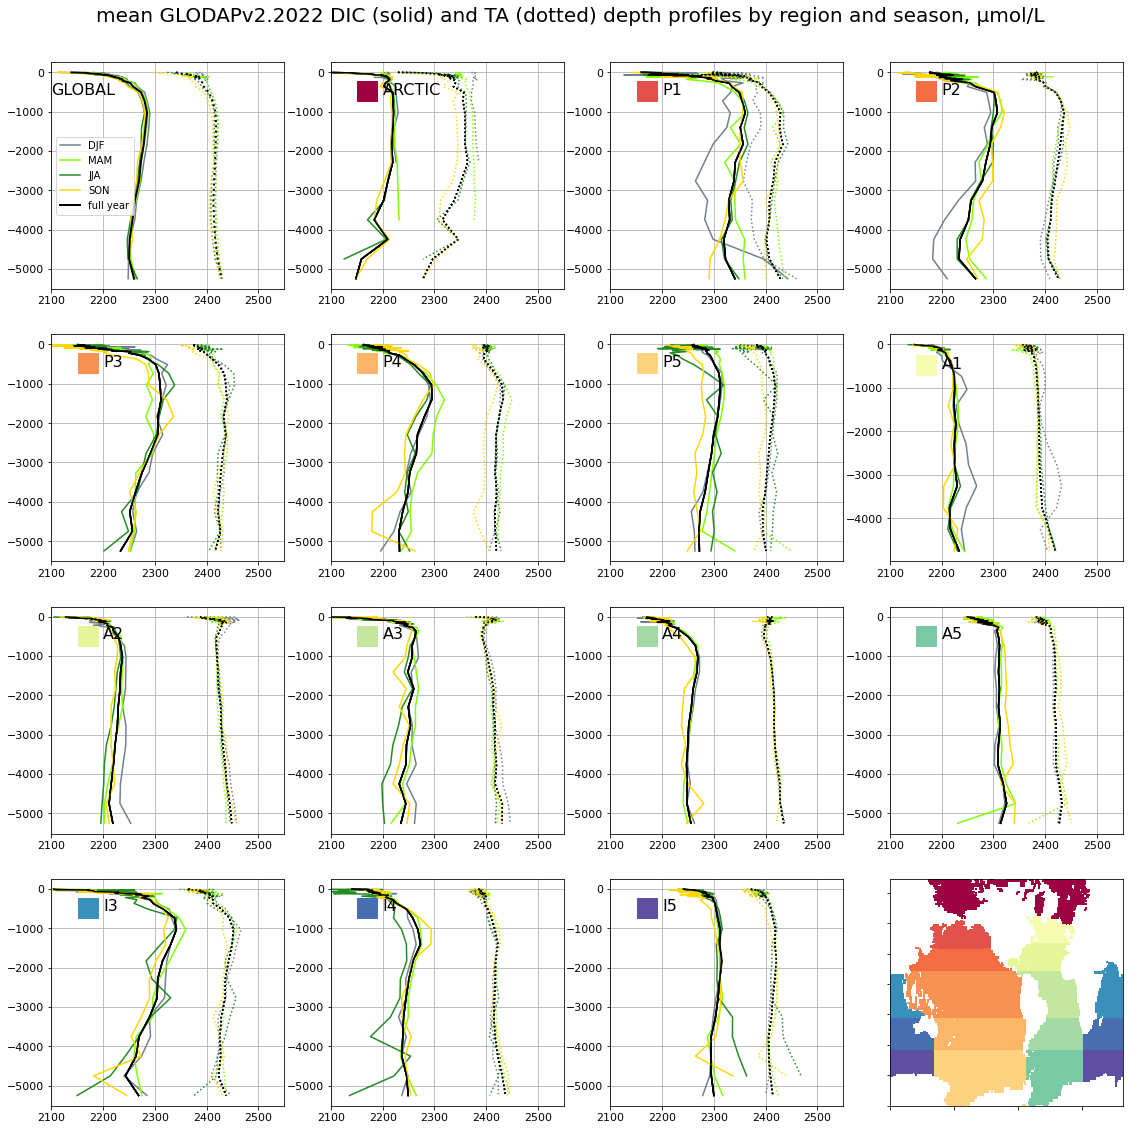

In [23]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']
seascol = ['slategrey', 'chartreuse', 'forestgreen', 'gold']
fig, axs = plt.subplots(4,4, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for r in range(0,4):
    axs[0].plot(allreg_DICseasonalDP[r,:], -depths, color = seascol[r],\
                    label = seasons[r])
    
    axs[0].plot(allreg_ALKseasonalDP[r,:], -depths, color = seascol[r], linestyle = ':')
axs[0].plot(allreg_DICfyDP, -depths, color = 'k', label = 'full year', linewidth = 2)
axs[0].plot(allreg_ALKfyDP, -depths, color = 'k', linestyle = ':', linewidth = 2)


for i in range(0,len(regs)):
    for r in range(0,4):
        axs[i+1].plot(regdict[regs[i]]['DICseasonalDP'][r,:],-depths, color = seascol[r],\
                    label = seasons[r])
        axs[i+1].plot(regdict[regs[i]]['ALKseasonalDP'][r,:],-depths, color = seascol[r], linestyle = ':',\
                    label = seasons[r])
        axs[i+1].plot(regdict[regs[i]]['DICfyDP'][:],-depths, color = 'k',\
                    label = seasons[r])
        axs[i+1].plot(regdict[regs[i]]['ALKfyDP'][:],-depths, color = 'k', linestyle = ':',\
                    label = seasons[r])
        
axs[15].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
axs[15].set_xticklabels([])
axs[15].set_yticklabels([])

axs[0].text(2100,-560,'GLOBAL', color = 'k', fontsize = 16)

for i in range(0,len(regs)):
    axs[i+1].plot(2170,-480,marker = "s", color = regdict[regs[i]]['colour'], markersize = 20)
    axs[i+1].text(2200,-560,regs[i], color = 'k', fontsize = 16)
for i in range(0,len(regs)+1):
    axs[i].set_xlim([2100,2550])
    axs[i].grid()
axs[0].legend(fontsize = 10)

plt.suptitle('mean GLODAPv2.2022 DIC (solid) and TA (dotted) depth profiles by region and season, µmol/L', fontsize = 20, y = 0.92)

Text(0.5, 0.95, 'GLODAP v2021.2, DIC (solid) and TA (dotted) depth profiles by region and season, µmol/L')

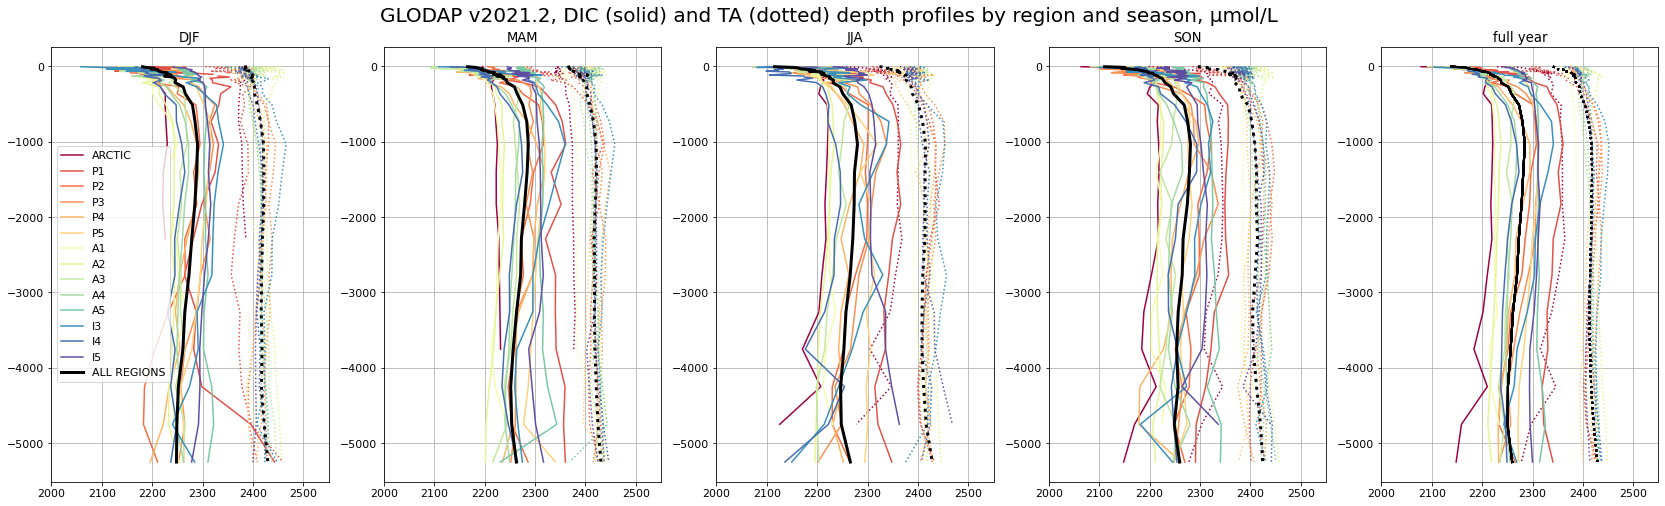

In [24]:


tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
depths = (tmesh['gdept_1d'][0])
    
fig, axs = plt.subplots(1,5, figsize=(18*fact, 5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,4):
    for r in range(0,len(regs)):
        axs[i].plot(regdict[regs[r]]['DICseasonalDP'][i,:],-depths, color = regdict[regs[r]]['colour'],\
                    label = regs[r])
        axs[i].plot(regdict[regs[r]]['ALKseasonalDP'][i,:],-depths, color = regdict[regs[r]]['colour'], linestyle = ':')
        
    axs[i].plot(allreg_DICseasonalDP[i,:], -depths, color = 'k', linewidth = 3,\
                    label = 'ALL REGIONS')
    axs[i].plot(allreg_ALKseasonalDP[i,:], -depths, color = 'k', linestyle = ':', linewidth = 3)
   
    axs[i].set_title(f'{seasons[i]}')
for r in range(0,len(regs)):
    axs[4].plot(regdict[regs[r]]['DICfyDP'][:],-depths, color = regdict[regs[r]]['colour'],\
                label = regs[r])
    axs[4].plot(regdict[regs[r]]['ALKfyDP'][:],-depths, color = regdict[regs[r]]['colour'], linestyle = ':')
    axs[4].plot(allreg_DICfyDP, -depths, color = 'k', label = 'full year', linewidth = 2)
    axs[4].plot(allreg_ALKfyDP, -depths, color = 'k', linestyle = ':', linewidth = 2)
    
axs[4].set_title('full year')

for i in range(0,5):
    axs[i].set_xlim([2000,2550])
    axs[i].grid()
axs[0].legend()

plt.suptitle('GLODAP v2021.2, DIC (solid) and TA (dotted) depth profiles by region and season, µmol/L', fontsize = 20, y = 0.95)

## the models, now


In [27]:
# get a regmask the size of the ocean
#RWdict['TOM12_RW_TES2']['name'] = 'milestone'
w2 = xr.open_dataset('//gpfs/data/greenocean/software/runs/TOM12_TJ_1ASA/ORCA2_1m_19900101_19901231_ptrc_T.nc')
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]


RWdict= {'TOM12_RW_TES2' : {'name' : 'milestone', 'color' : 'darkcyan'},
         'TOM12_RW_3G09' : {'name' : 'top grazer' , 'color' : 'rebeccapurple'} ,
         'TOM12_RW_3G30' : {'name' : 'pPFT & nutrients', 'color' : 'violet'},
         'TOM12_RW_3G32' : {'name' : 'carbon flux' , 'color' : 'firebrick'},
         'TOM12_RW_3G34' : {'name' : 'combination' , 'color' : 'orange'}}
RWmods = ['TOM12_RW_TES2', 'TOM12_RW_3G09', 'TOM12_RW_3G30', 'TOM12_RW_3G32' ,'TOM12_RW_3G34']

csize_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]


for r in range(0, len(RWmods)):
    yst = 1955; yen = 1960; dtype = 'ptrc_T'; modnam = RWmods[r]
    ylist = ut.make_yearlist(yst, yen, dtype, modnam)
    tdat = xr.open_mfdataset(ylist)

    DIC = np.nanmean(tdat.DIC.resample(time_counter="Y").mean().values, axis = 0)
    ALK = np.nanmean(tdat.Alkalini.resample(time_counter="Y").mean().values, axis = 0)



    DIC_mean = np.zeros([31])
    ALK_mean = np.zeros([31])
    for i in range(0,31):
        DIC_mean[i] = np.ma.average(DIC[i,:,:], weights = cvol[i,:,:]) * 1e6
        ALK_mean[i] = np.ma.average(ALK[i,:,:], weights = cvol[i,:,:]) * 1e6
        
    # print(DIC_mean)
    RWdict[modnam]['DIC_mean'] = DIC_mean
    RWdict[modnam]['ALK_mean'] = ALK_mean
    
    
#1  = milestone equivalent (but with three-parameter growth)
# TOM12_RW_3G09 = top grazer (tuning of jellyfish and macrozooplankton mortality and mesozooplankton respiration)
# TOM12_RW_3G30 = pPFT & nutrients (half-saturation constant for protozooplankton grazing)
# TOM12_RW_3G32 = carbon flux & nutrients (bacterial respiration)
# TOM12_RW_3G34 = combination (3G30, 3G32 and additional macrozooplankton mortality)]

# get model, subdivide years of choice, load mfdataset

# multiply out to get mean depth profile - don't do by region. 

NameError: name 'tco2' is not defined

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, pressure_surface: 33, snr: 1, time: 2)
Coordinates:
  * lon          (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat          (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 86.0 87.0 88.0 89.0
Dimensions without coordinates: pressure_surface, snr, time
Data variables:
    tco2         (time, pressure_surface, lat, lon) float64 ...
    tco2_error   (time, pressure_surface, lat, lon) float64 ...
    Input_mean   (time, pressure_surface, lat, lon) float64 ...
    Input_std    (time, pressure_surface, lat, lon) float64 ...
    Input_N      (time, pressure_surface, lat, lon) float64 ...
    Input_lon    (time, pressure_surface, lat, lon) float64 ...
    Input_lat    (time, pressure_surface, lat, lon) float64 ...
    tco2_relerr  (time, pressure_surface, lat, lon) float64 ...
    SnR          (snr) float64 ...
    CL           (pressure_surface) float64 ...
    Pressure     (pressure_surface) float64 ...
Attributes:
  

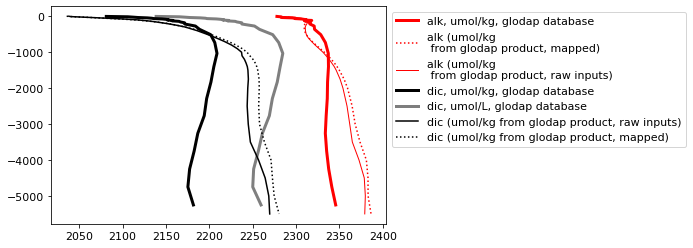

In [28]:
theta = xr.open_dataset('/gpfs/data/greenocean/observations/GLODAPv2_Mapped_Climatologies/GLODAPv2.theta.nc')
tco2 = xr.open_dataset('/gpfs/data/greenocean/observations/GLODAPv2_Mapped_Climatologies/GLODAPv2.tco2.nc')
talk = xr.open_dataset('/gpfs/data/greenocean/observations/GLODAPv2_Mapped_Climatologies/GLODAPv2.talk.nc')

## alkalinity
talk_in = np.nanmean(np.nanmean(talk['Input_mean'][:,:,:],axis = 2),axis = 1)


plt.plot(allreg_ALK_umolkg_fyDP,-depths, color = 'r', linewidth = 3, label = 'alk, umol/kg, glodap database')
#plt.plot(allreg_ALKfyDP,-depths, color = 'r', linewidth = 3, alpha = 0.5, label = 'alk, umol/L, glodap database')
talk_map = np.nanmean(np.nanmean(talk['talk'][:,:,:],axis = 2),axis = 1)
plt.plot(talk_map, -talk['Pressure'], color = 'r', linestyle = ':', label = 'alk (umol/kg \n from glodap product, mapped)')
plt.plot(talk_in, -talk['Pressure'], color = 'r', linewidth = 1, label = 'alk (umol/kg \n from glodap product, raw inputs)')

####
plt.plot(allreg_DIC_umolkg_fyDP,-depths, color = 'k', linewidth = 3, label = 'dic, umol/kg, glodap database')
plt.plot(allreg_DICfyDP,-depths, color = 'k', linewidth = 3, alpha = 0.5, label = 'dic, umol/L, glodap database')
print(tco2)
tco2_in = np.nanmean(np.nanmean(tco2['Input_mean'][1,:,:,:],axis = 2),axis = 1)
print(np.shape(tco2_in))
plt.plot(tco2_in, -tco2['Pressure'], color = 'k', label = 'dic (umol/kg from glodap product, raw inputs)')
tco2_map = np.nanmean(np.nanmean(tco2['tco2'][1,:,:,:],axis = 2),axis = 1)
print(np.shape(tco2_map))
plt.plot(tco2_map, -tco2['Pressure'], color = 'k', linestyle = ':', label = 'dic (umol/kg from glodap product, mapped)')

plt.legend(bbox_to_anchor = [1, 1])

In [29]:
## tomorrow - convert glodap to umol/L

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, pressure_surface: 33, snr: 1, time: 2)
Coordinates:
  * lon          (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat          (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 86.0 87.0 88.0 89.0
Dimensions without coordinates: pressure_surface, snr, time
Data variables:
    tco2         (time, pressure_surface, lat, lon) float64 ...
    tco2_error   (time, pressure_surface, lat, lon) float64 ...
    Input_mean   (time, pressure_surface, lat, lon) float64 ...
    Input_std    (time, pressure_surface, lat, lon) float64 ...
    Input_N      (time, pressure_surface, lat, lon) float64 ...
    Input_lon    (time, pressure_surface, lat, lon) float64 ...
    Input_lat    (time, pressure_surface, lat, lon) float64 ...
    tco2_relerr  (time, pressure_surface, lat, lon) float64 ...
    SnR          (snr) float64 ...
    CL           (pressure_surface) float64 ...
    Pressure     (pressure_surface) float64 0.0 10.0 20.0 ... 

Text(0.5, 1.0, 'TA-DIC, µmol/L')

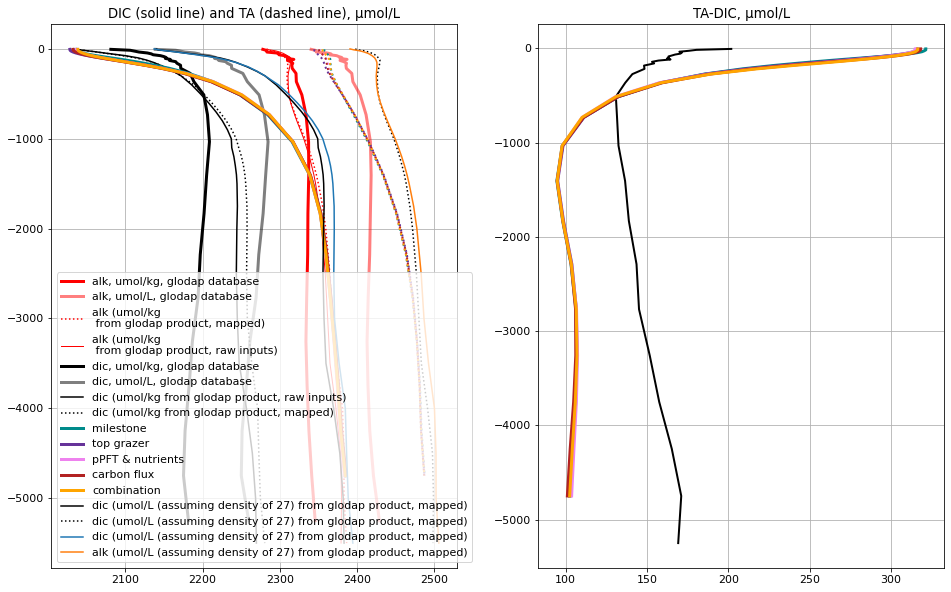

In [30]:
fact = 2    
fig, axs = plt.subplots(1,2, figsize=(8*fact, 5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
# axs[0].plot(allreg_DICfyDP, -depths, color = 'k', label = 'OBSERVATIONS', linewidth = 2)
# axs[0].plot(allreg_ALKfyDP, -depths, color = 'k', linestyle = ':', linewidth = 2)

axs[0].plot(allreg_ALK_umolkg_fyDP,-depths, color = 'r', linewidth = 3, label = 'alk, umol/kg, glodap database')
axs[0].plot(allreg_ALKfyDP,-depths, color = 'r', linewidth = 3, alpha = 0.5, label = 'alk, umol/L, glodap database')
talk_map = np.nanmean(np.nanmean(talk['talk'][:,:,:],axis = 2),axis = 1)
axs[0].plot(talk_map, -talk['Pressure'], color = 'r', linestyle = ':', label = 'alk (umol/kg \n from glodap product, mapped)')
axs[0].plot(talk_in, -talk['Pressure'], color = 'r', linewidth = 1, label = 'alk (umol/kg \n from glodap product, raw inputs)')

####
axs[0].plot(allreg_DIC_umolkg_fyDP,-depths, color = 'k', linewidth = 3, label = 'dic, umol/kg, glodap database')
axs[0].plot(allreg_DICfyDP,-depths, color = 'k', linewidth = 3, alpha = 0.5, label = 'dic, umol/L, glodap database')
print(tco2)
tco2_in = np.nanmean(np.nanmean(tco2['Input_mean'][1,:,:,:],axis = 2),axis = 1)
print(np.shape(tco2_in))
axs[0].plot(tco2_in, -tco2['Pressure'], color = 'k', label = 'dic (umol/kg from glodap product, raw inputs)')
tco2_map = np.nanmean(np.nanmean(tco2['tco2'][1,:,:,:],axis = 2),axis = 1)
print(np.shape(tco2_map))
axs[0].plot(tco2_map, -tco2['Pressure'], color = 'k', linestyle = ':', label = 'dic (umol/kg from glodap product, mapped)')


axs[1].plot(allreg_ALKfyDP-allreg_DICfyDP, -depths, color = 'k', linewidth = 2)



for r in range(0, len(RWmods)):
    modnam = RWmods[r]
    axs[0].plot(RWdict[modnam]['DIC_mean'], -depths, color = RWdict[modnam]['color'],\
                label = RWdict[modnam]['name'], linewidth = 3)
    axs[0].plot(RWdict[modnam]['ALK_mean'], -depths, color = RWdict[modnam]['color'],\
                linewidth = 2, linestyle = ':')
    axs[1].plot((RWdict[modnam]['ALK_mean']-RWdict[modnam]['DIC_mean']), -depths, color = RWdict[modnam]['color'],\
                label = RWdict[modnam]['name'], linewidth = 3)

densfact = 1.05 #(kgs per L)
tco2_in = np.nanmean(np.nanmean(tco2['Input_mean'][1,:,:,:],axis = 2),axis = 1)
print(np.shape(tco2_in))
axs[0].plot(tco2_in * densfact, -tco2['Pressure'], color = 'k', \
            label = 'dic (umol/L (assuming density of 27) from glodap product, mapped)')
talk_in = np.nanmean(np.nanmean(talk['Input_mean'][:,:,:],axis = 2),axis = 1)
axs[0].plot(talk_in* densfact, -talk['Pressure'], color = 'k', linestyle = ':', \
            label = 'dic (umol/L (assuming density of 27) from glodap product, mapped)')

tco2_map = np.nanmean(np.nanmean(tco2['tco2'][1,:,:,:],axis = 2),axis = 1)
print(np.shape(tco2_map))
axs[0].plot(tco2_map* densfact, -tco2['Pressure'], label = 'dic (umol/L (assuming density of 27) from glodap product, mapped)')
talk_map = np.nanmean(np.nanmean(talk['talk'][:,:,:],axis = 2),axis = 1)
axs[0].plot(talk_map* densfact, -talk['Pressure'], label = 'alk (umol/L (assuming density of 27) from glodap product, mapped)')
    
    
    
for i in range(0,2):
    #axs[i].set_xlim([2000,2550])
    axs[i].grid()
    
axs[0].legend()
axs[0].set_title('DIC (solid line) and TA (dashed line), µmol/L')
axs[1].set_title('TA-DIC, µmol/L')

    #axs[i].plot(allreg_ALKfyDP, -depths, color = 'k', linestyle = ':', linewidth = 2)

# other explorations and experiments that we will not worry about for the time being 

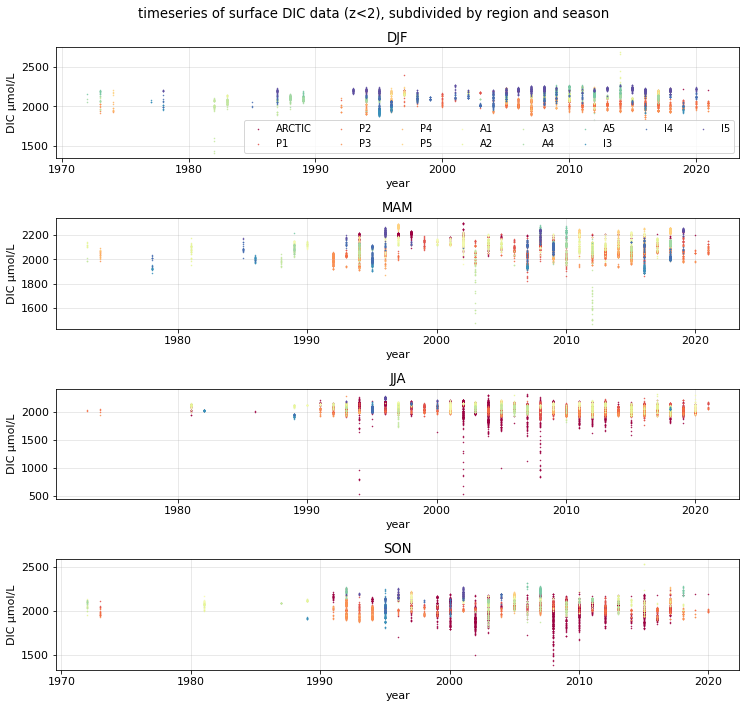

In [31]:
ttit = 'timeseries of surface DIC data (z<2), subdivided by region and season'

fact = 0.5
fig, axs = plt.subplots(4,1, figsize=(21*fact, 20*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tit = ['DJF', 'MAM', 'JJA', 'SON']
for a in range(1,5):
    for i in range(0,len(regs)):
        filt = ((tREG == regdict[regs[i]]['number']) & (tZ < 2) & (tSEAS == a))
        axs[a-1].plot(tYEAR[filt],tDIC[filt], color = regdict[regs[i]]['colour'], marker = '.', markersize = 1, linestyle = '', label = regs[i])
        axs
        #axs[a-1].plot([1500,2700],[1500,2700], 'k-')
        #axs[a-1].set_xlim([1900,2500])
        #axs[a-1].set_ylim([1900,2500])
    axs[a-1].grid(alpha = 0.35)
    axs[a-1].set_xlabel('year')
    axs[a-1].set_ylabel('DIC µmol/L')
    axs[a-1].set_title(tit[a-1])
axs[0].legend(ncol = 8, loc = 'best', fontsize = 10)
plt.suptitle(ttit)
plt.tight_layout()


###### looking in property-property spaces (namely TA vs DIC space and carbonate chemistry vs salinity space), surface data since 2010:

We see some regionalizations (clusterings), but it's not super helpful...

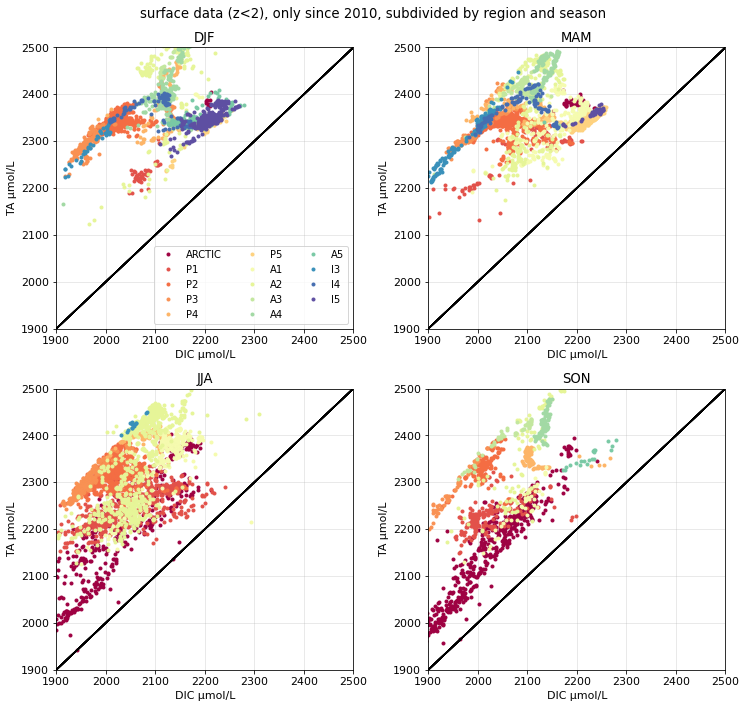

In [32]:
ttit = 'surface data (z<2), only since 2010, subdivided by region and season'
fact = 0.5
fig, axs = plt.subplots(2,2, figsize=(21*fact, 20*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tit = ['DJF', 'MAM', 'JJA', 'SON']
for a in range(1,5):
    for i in range(0,len(regs)):
        filt = ((tREG == regdict[regs[i]]['number']) & (tZ < 2) & (tYEAR > 2010) & (tSEAS == a))
        axs[a-1].plot(tDIC[filt],tALK[filt], color = regdict[regs[i]]['colour'], marker = '.', linestyle = '', label = regs[i])
        axs[a-1].plot([1500,2700],[1500,2700], 'k-')
        axs[a-1].set_xlim([1900,2500])
        axs[a-1].set_ylim([1900,2500])
    axs[a-1].grid(alpha = 0.35)
    axs[a-1].set_xlabel('DIC µmol/L')
    axs[a-1].set_ylabel('TA µmol/L')
    axs[a-1].set_title(tit[a-1])
axs[0].legend(ncol = 3, loc = 'best', fontsize = 10)
plt.suptitle(ttit)
plt.tight_layout()


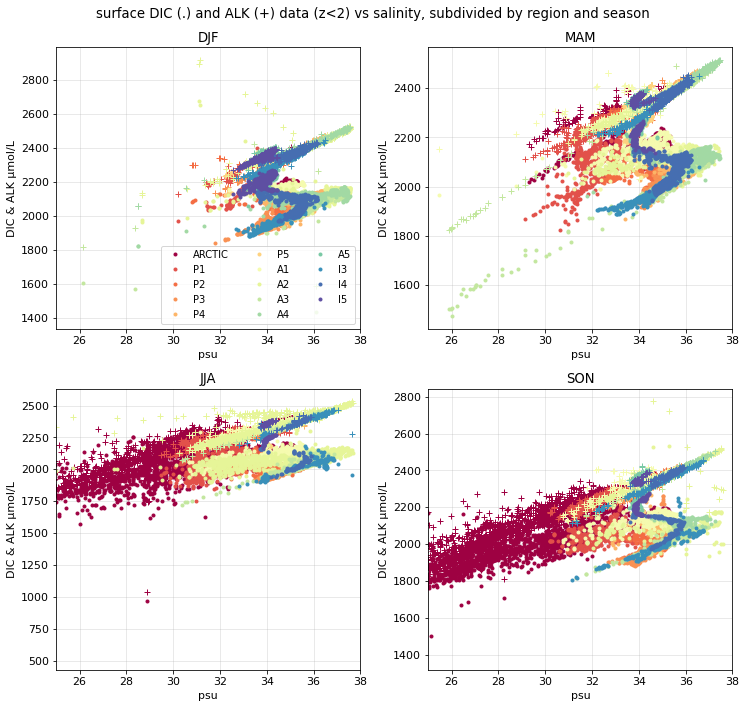

In [33]:
ttit = 'surface DIC (.) and ALK (+) data (z<2) vs salinity, subdivided by region and season'

fact = 0.5
fig, axs = plt.subplots(2,2, figsize=(21*fact, 20*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tit = ['DJF', 'MAM', 'JJA', 'SON']
for a in range(1,5):
    for i in range(0,len(regs)):
        filt = ((tREG == regdict[regs[i]]['number']) & (tZ < 2) & (tSEAS == a))
        axs[a-1].plot(tSAL[filt],tDIC[filt], color = regdict[regs[i]]['colour'], marker = '.', linestyle = '', label = regs[i])
        axs[a-1].plot(tSAL[filt],tALK[filt], color = regdict[regs[i]]['colour'], marker = '+', linestyle = '')

        #axs[a-1].plot([1500,2700],[1500,2700], 'k-')
    axs[a-1].set_xlim([25,38])
        #axs[a-1].set_ylim([1900,2500])
    axs[a-1].grid(alpha = 0.35)
    axs[a-1].set_xlabel('psu')
    axs[a-1].set_ylabel('DIC & ALK µmol/L')
    axs[a-1].set_title(tit[a-1])
axs[0].legend(ncol = 3, loc = 'best', fontsize = 10)
plt.suptitle(ttit)
plt.tight_layout()


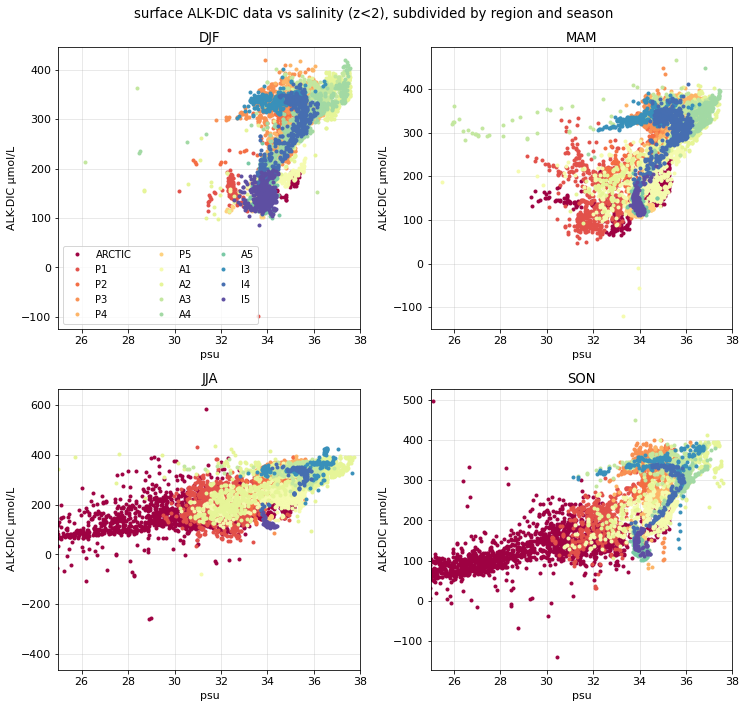

In [34]:
ttit = 'surface ALK-DIC data vs salinity (z<2), subdivided by region and season'

fact = 0.5
fig, axs = plt.subplots(2,2, figsize=(21*fact, 20*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tit = ['DJF', 'MAM', 'JJA', 'SON']
for a in range(1,5):
    for i in range(0,len(regs)):
        filt = ((tREG == regdict[regs[i]]['number']) & (tZ < 2) & (tSEAS == a))
        axs[a-1].plot(tSAL[filt],tALK[filt]-tDIC[filt], color = regdict[regs[i]]['colour'], marker = '.', linestyle = '', label = regs[i])
        #axs[a-1].plot(tSAL[filt],, color = regdict[regs[i]]['colour'], marker = '+', linestyle = '')

        #axs[a-1].plot([1500,2700],[1500,2700], 'k-')
    axs[a-1].set_xlim([25,38])
        #axs[a-1].set_ylim([1900,2500])
    axs[a-1].grid(alpha = 0.35)
    axs[a-1].set_xlabel('psu')
    axs[a-1].set_ylabel('ALK-DIC µmol/L')
    axs[a-1].set_title(tit[a-1])
axs[0].legend(ncol = 3, loc = 'best', fontsize = 10)
plt.suptitle(ttit)
plt.tight_layout()


# D) plotting surface seasonal cycles is too random and has the problem of sparse data

it's a dog's breakfast & we're back in abstract art territory

In [35]:

for i in range(0,len(regs)):
    filt = ((tREG == regdict[regs[i]]['number']) & (tZ < 2) & (tYEAR > 2010))
    DIC_surface = np.zeros([2,12])
    ALK_surface = np.zeros([2,12])
    ALKDIC_surface = np.zeros([2,12])
    for m in range(1,13):
        filt = ((tREG == regdict[regs[i]]['number']) & (tZ < 2) & (tYEAR > 2010) & (tMONTH == m))
        DIC_surface[0,m-1] = np.nanmean(tDIC[filt])
        DIC_surface[1,m-1] = np.nanstd(tDIC[filt])
        ALK_surface[0,m-1] = np.nanmean(tALK[filt])
        ALK_surface[1,m-1] = np.nanstd(tALK[filt])
        ALKDIC_surface[0,m-1] =np.nanmean(tALK[filt]-tDIC[filt])
        ALKDIC_surface[1,m-1] =np.nanstd(tALK[filt]-tDIC[filt])
    regdict[regs[i]]['DIC_surface'] = DIC_surface
    regdict[regs[i]]['ALK_surface'] = ALK_surface
    regdict[regs[i]]['ALKDIC_surface'] = ALKDIC_surface
  
for i in range(0,len(regs)):
    filt = ((tREG == regdict[regs[i]]['number']) & (tZ < 2) & (tYEAR > 2010))
    DIC_surfaceSEAS = np.zeros([2,4])
    ALK_surfaceSEAS = np.zeros([2,4])
    ALKDIC_surfaceSEAS = np.zeros([2,4])
    for m in range(1,5):
        filt = ((tREG == regdict[regs[i]]['number']) & (tZ < 2) & (tYEAR > 2010) & (tSEAS == m))

        DIC_surfaceSEAS[0,m-1] = np.nanmean(tDIC[filt])
        DIC_surfaceSEAS[1,m-1] = np.nanstd(tDIC[filt])
        ALK_surfaceSEAS[0,m-1] = np.nanmean(tALK[filt])
        ALK_surfaceSEAS[1,m-1] = np.nanstd(tALK[filt])
        ALKDIC_surfaceSEAS[0,m-1] =np.nanmean(tALK[filt]-tDIC[filt])
        ALKDIC_surfaceSEAS[1,m-1] =np.nanstd(tALK[filt]-tDIC[filt])

    regdict[regs[i]]['DIC_surfaceSEAS'] = DIC_surfaceSEAS
    regdict[regs[i]]['ALK_surfaceSEAS'] = ALK_surfaceSEAS
    regdict[regs[i]]['ALKDIC_surfaceSEAS'] = ALKDIC_surfaceSEAS

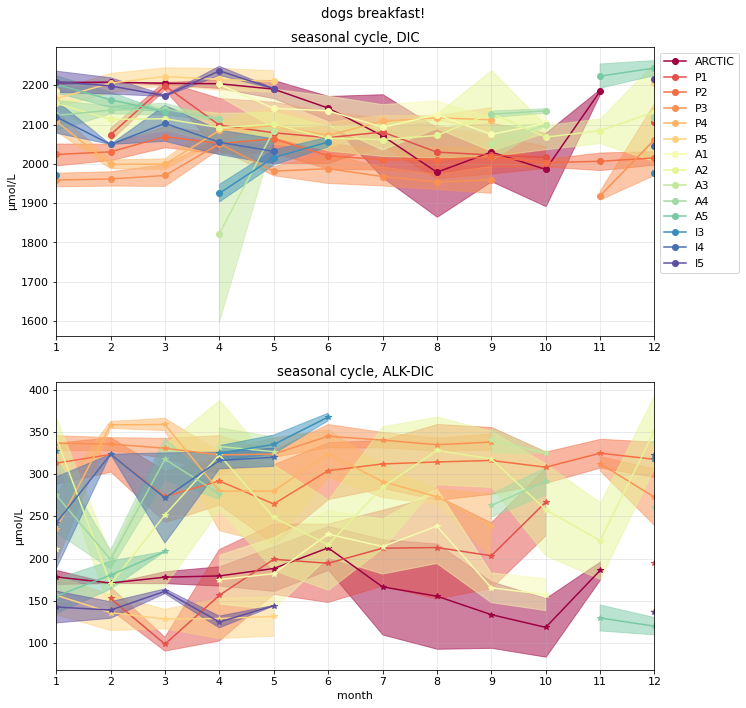

In [36]:
fact = 0.5
fig, axs = plt.subplots(2,1, figsize=(21*fact, 20*fact), facecolor='w', edgecolor='k')
m
mons = np.arange(1,13,1)
for i in range(0,len(regs)):
    pica = regdict[regs[i]]['DIC_surface'][0,:]
    pica2 = regdict[regs[i]]['DIC_surface'][1,:]
    axs[0].plot(mons, pica,\
                marker = 'o', color = regdict[regs[i]]['colour'], label = regs[i])
    axs[0].fill_between(mons, pica+pica2, pica-pica2, \
                        color = regdict[regs[i]]['colour'], alpha = 0.5)
    
 
    
    pica = regdict[regs[i]]['ALKDIC_surface'][0,:]
    pica2 = regdict[regs[i]]['ALKDIC_surface'][1,:]
    axs[1].plot(mons, pica,\
                marker = '*', color = regdict[regs[i]]['colour'])
    axs[1].fill_between(mons, pica+pica2, pica-pica2, \
                        color = regdict[regs[i]]['colour'], alpha = 0.5)
axs[0].set_title('seasonal cycle, DIC')  
axs[1].set_title('seasonal cycle, ALK-DIC')    
axs[0].legend(bbox_to_anchor = [1,1])

for i in range(0,2):
    axs[i].set_xlim([1,12])
    axs[i].set_xticks(np.arange(1,13,1))
    axs[i].grid(alpha = 0.3)
    axs[i].set_ylabel('µmol/L')
    axs[1].set_xlabel('month')
plt.suptitle('dogs breakfast!')
plt.tight_layout()


seasonal resolution is, if possible, even worse

mean DIC concentration, summer to winter, by season
ARCTIC
[2206.85998095 2196.87255182 1996.77420271 2014.97659161]
P1
[2075.84594065 2083.76620447 2052.41304913 2022.28570796]
P2
[2024.85402421 2060.81920398 2013.9017648  2011.50749997]
P3
[1993.93703074 2013.70454462 1961.34832173 1953.23444899]
P4
[2111.5214891  2075.5892455  2103.82952737 2112.22751538]
P5
[2187.59288873 2216.94192545           nan           nan]
A1
[2185.80577485 2148.65790515 2121.35986678 2090.0405116 ]
A2
[2134.64381003 2100.31452099 2065.1203895  2103.75866132]
A3
[2117.36436102 1991.33065133           nan 2054.76549611]
A4
[2123.85569675 2136.14811161           nan 2133.98033979]
A5
[2188.54516533 2132.91722403           nan 2223.53688963]
I3
[1974.27317539 1968.17740075 2055.73230183           nan]
I4
[2102.42060224 2078.50218941           nan           nan]
I5
[2205.96943188 2229.85656886           nan           nan]


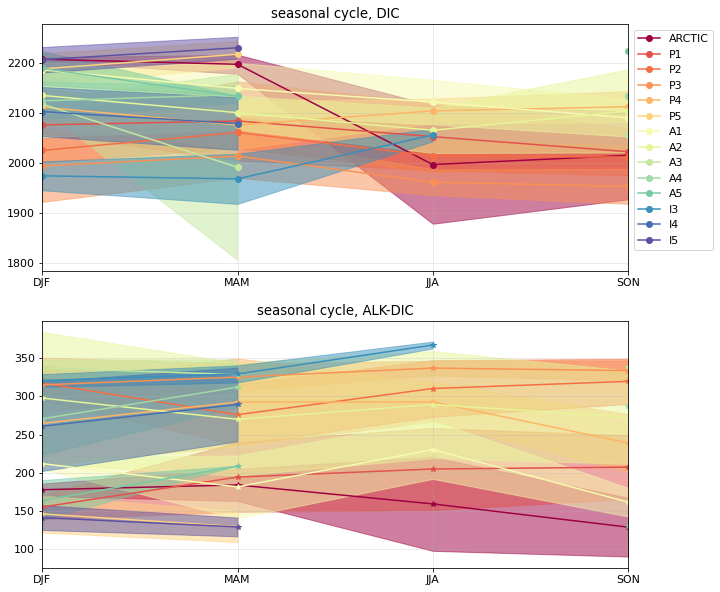

In [37]:
fact = 0.5
fig, axs = plt.subplots(2,1, figsize=(21*fact, 20*fact), facecolor='w', edgecolor='k')
print('mean DIC concentration, summer to winter, by season')
mons = np.arange(1,5,1)
for i in range(0,len(regs)):
    pica = regdict[regs[i]]['DIC_surfaceSEAS'][0,:]
    print(regs[i])
    print(regdict[regs[i]]['DIC_surfaceSEAS'][0,:])
    pica2 = regdict[regs[i]]['DIC_surfaceSEAS'][1,:]
    axs[0].plot(mons, pica,\
                marker = 'o', color = regdict[regs[i]]['colour'], label = regs[i])
    axs[0].fill_between(mons, pica+pica2, pica-pica2, \
                        color = regdict[regs[i]]['colour'], alpha = 0.5)
    
 
    
    pica = regdict[regs[i]]['ALKDIC_surfaceSEAS'][0,:]
    pica2 = regdict[regs[i]]['ALKDIC_surfaceSEAS'][1,:]
    axs[1].plot(mons, pica,\
                marker = '*', color = regdict[regs[i]]['colour'])
    axs[1].fill_between(mons, pica+pica2, pica-pica2, \
                        color = regdict[regs[i]]['colour'], alpha = 0.5)
axs[0].set_title('seasonal cycle, DIC')  
axs[1].set_title('seasonal cycle, ALK-DIC')    
axs[0].legend(bbox_to_anchor = [1,1])

for i in range(0,2):
    axs[i].set_xlim([1,4])
    axs[i].set_xticks(np.arange(1,5,1))
    axs[i].set_xticklabels(['DJF','MAM','JJA','SON'])
    axs[i].grid(alpha = 0.3)
# def plotcyc(dic, ta, latband, ind):
#     mons = np.arange(1,13,1)
#     pica = dic[latband,0,:]; pica2 = dic[latband,1,:] 
#     axs[ind].plot(mons, pica, 'ko-', label = 'DIC')
#     axs[ind].fill_between(mons, pica+pica2, pica-pica2, color = 'k', alpha = 0.5)
#     pica = ta[latband,0,:]; pica2 = ta[latband,1,:] 
#     axs[ind].plot(mons, pica, 'k.:', label = 'TA')
#     axs[ind].fill_between(mons, pica+pica2, pica-pica2, color = 'k', alpha = 0.2)
    

### Random other bits of code and misc. 

# C) characterizing surface data as a short timeseries and also in property-property space
As we somewhat expect, the timeseries of (surface) data (coloured by region) - shows no obvious time-trend, even though one is expected in reality and would exist in model averages - the sampling is (likely) too random for that. We see vague regional differences, and we also see some freshwater/meltwater signatures, especially in the Arctic in boreal summer and autumn. 

In [38]:
w = xr.open_dataset('/gpfs/data/greenocean/observations/GLODAPv2_Mapped_Climatologies/GLODAPv2.tco2.nc')


In [39]:
# pd.read_csv('test.csv', index_col=0, nrows=0).columns.tolist()
# 
import pandas as pd
tdir = '/gpfs/data/greenocean/observations/'
glodap = pd.read_csv(f'{tdir}GLODAPv2.2022_Merged_Master_File.csv', index_col=0, nrows=0).columns.tolist()
print(glodap)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#print(glodap.head())
print('managed2readcsv')

['G2cruise', 'G2station', 'G2region', 'G2cast', 'G2year', 'G2month', 'G2day', 'G2hour', 'G2minute', 'G2latitude', 'G2longitude', 'G2bottomdepth', 'G2maxsampdepth', 'G2bottle', 'G2pressure', 'G2depth', 'G2temperature', 'G2theta', 'G2salinity', 'G2salinityf', 'G2salinityqc', 'G2sigma0', 'G2sigma1', 'G2sigma2', 'G2sigma3', 'G2sigma4', 'G2gamma', 'G2oxygen', 'G2oxygenf', 'G2oxygenqc', 'G2aou', 'G2aouf', 'G2nitrate', 'G2nitratef', 'G2nitrateqc', 'G2nitrite', 'G2nitritef', 'G2silicate', 'G2silicatef', 'G2silicateqc', 'G2phosphate', 'G2phosphatef', 'G2phosphateqc', 'G2tco2', 'G2tco2f', 'G2tco2qc', 'G2talk', 'G2talkf', 'G2talkqc', 'G2fco2', 'G2fco2f', 'G2fco2temp', 'G2phts25p0', 'G2phts25p0f', 'G2phtsinsitutp', 'G2phtsinsitutpf', 'G2phtsqc', 'G2cfc11', 'G2pcfc11', 'G2cfc11f', 'G2cfc11qc', 'G2cfc12', 'G2pcfc12', 'G2cfc12f', 'G2cfc12qc', 'G2cfc113', 'G2pcfc113', 'G2cfc113f', 'G2cfc113qc', 'G2ccl4', 'G2pccl4', 'G2ccl4f', 'G2ccl4qc', 'G2sf6', 'G2psf6', 'G2sf6f', 'G2sf6qc', 'G2c13', 'G2c13f', 'G2c1

welp, that didn't help